In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz 
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
data = pd.read_csv('../data/clean_data/data_v1.csv', index_col=0)
data = data[data['poverty_ratio'] != 'NOT IN POVERTY UNIVERSE']
data.head()

,age,job_industry_recode,school_enroll_lastweek,employment,fam_size,full_time_work,full_part_school,highest_education,hs_col_unenrolled,weekly_earnings,...,poverty_ratio,family_earn_ly,fam_id,fam_med_costs,fam_outofpocket_med_costs,fam_otc_med_costs,fam_rent_val,fips,state,state.1
1,67,"Not in universe, or children",Not in univ. or children & Armed Forces,0,0,0,0,Some College But No Degree,0,0,...,BELOW POVERTY LEVEL,0,1,0,0,0,0,ME,4,23
2,74,"Not in universe, or children",Not in univ. or children & Armed Forces,0,0,0,0,High school graduate-high school diploma,0,0,...,BELOW POVERTY LEVEL,0,1,0,60,60,0,ME,4,23
3,66,"Not in universe, or children",Not in univ. or children & Armed Forces,0,1,0,0,High school graduate-high school diploma,0,0,...,150 AND ABOVE THE POVERTY LEVEL,0,1,0,0,0,0,ME,3,23
4,68,"Not in universe, or children",Not in univ. or children & Armed Forces,0,1,0,0,High school graduate-high school diploma,0,0,...,150 AND ABOVE THE POVERTY LEVEL,0,1,0,0,0,0,ME,3,23
5,52,"Not in universe, or children",No,0,1,0,0,High school graduate-high school diploma,0,0,...,150 AND ABOVE THE POVERTY LEVEL,42000,1,50,1370,0,0,ME,3,23


In [20]:
pd.set_option('display.max_columns', 10)

In [14]:
data['age_recode_gt15'].value_counts()

age_recode_gt15
Not In Universe      29208
75 years and over    10363
35 to 39 years       10171
40 to 44 years       10076
30 to 34 years        9758
45 to 49 years        8989
50 to 54 years        8988
55 to 59 years        8413
25 to 29 years        8282
65 to 69 years        8019
70 to 74 years        6817
62 to 64 years        5194
22 to 24 years        4695
16 and 17 years       4365
18 and 19 years       3685
60 to 61 years        3452
20 and 21 years       3106
15 years              2277
Name: count, dtype: int64

In [21]:
## filter for necessary columns as determined by NB
cols = ['federal_gross_income_adj', 
        'fam_size', 
        'age', 
        'fam_med_costs', 
        'weeks_unemployed', 
        'hours_worked',
        #have to encode below all are non ordinal so will be one hot encoding
        'job_industry_recode', 
        'age_recode_gt15', 
        'highest_education', 
        'marital_status', 
        'ft_pt_unem', 
        'labor_force_recode', 
        'sex']
education_map = {"Children":"Less than highschool",
                "11th Grade" : "Less than highschool",
                "10th Grade": "Less than highschool",
                "9th Grade" : "Less than highschool",
                "7th and 8th grade" : "Less than highschool",
                "12th Grade No Diploma" : "Less than highschool",
                "5th Or 6th Grade" : "Less than highschool",
                "1st,2nd,3rd,or 4th grade": "Less than highschool",
                "Less Than 1st Grade": "Less than highschool",
                "Bachelor's degree (BA,AB,BS)" : "Undergrad",
                "Master's degree (MA,MS,MENG,MED,MSW,MBA)": "Masters or Higher",
                "Doctorate degree (PHD,EDD)" : "Masters or Higher",
                "Professional school degree (MD,DDS,DVM,L" : "Masters or Higher",
                "Some College But No Degree" : "Some College",
                "Assc degree-academic program" : "Some College",
                "Assc degree-occupation/vocation" : "Some College"
}
age_map = {
        '75 years and over' : '65+',
        '35 to 39 years': '30-39',
        '40 to 44 years': '40-49',      
        '30 to 34 years': '30-39',        
        '45 to 49 years': '40-49',
        '50 to 54 years': '50-59',
        '55 to 59 years': '50-59',        
        '25 to 29 years': '20-29',        
        '65 to 69 years': '65+',        
        '70 to 74 years': '65+',        
        '62 to 64 years': '60-65',       
        '22 to 24 years': '20-29',        
        '16 and 17 years': '15-19',       
        '18 and 19 years': '15-19',
        '60 to 61 years': '60-65',        
        '20 and 21 years': '20-29',       
        '15 years': '15-19' 
}
data.highest_education = data.highest_education.map(education_map)
data.age_recode_gt15 = data.age_recode_gt15.map(age_map)
tree_data = data.loc[:,cols]
tree_data_encoded = pd.get_dummies(tree_data, columns=['job_industry_recode', 
        'age_recode_gt15', 
        'highest_education', 
        'marital_status', 
        'ft_pt_unem', 
        'labor_force_recode', 
        'sex'],
        drop_first=False,
        dtype=int)
tree_data_encoded.head()

,federal_gross_income_adj,fam_size,age,fam_med_costs,weeks_unemployed,...,"labor_force_recode_Unemp,on layoff","labor_force_recode_W/job,not at work",labor_force_recode_Working,sex_Female,sex_Male
1,0,0,67,0,0,...,0,0,0,1,0
2,9,0,74,0,0,...,0,0,0,0,1
3,0,1,66,0,0,...,0,0,0,1,0
4,2400,1,68,0,0,...,0,0,0,1,0
5,47828,1,52,50,0,...,0,0,0,1,0


In [22]:
rus = RandomUnderSampler()
x = tree_data_encoded
y = data['poverty_ratio']
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    random_state=1111,
    test_size = 0.2
)
X_train_rus, y_train_rus = rus.fit_resample(x_train, y_train)

[Text(0.7558420282899969, 0.9761904761904762, 'x[0] <= 45016.0\nentropy = 2.0\nsamples = 17840\nvalue = [4460, 4460, 4460, 4460]'),
 Text(0.5189391465243633, 0.9285714285714286, 'x[3] <= 372.5\nentropy = 1.984\nsamples = 16315\nvalue = [4433, 4356, 3067, 4459]'),
 Text(0.3262291237632203, 0.8809523809523809, 'x[0] <= 17795.0\nentropy = 1.882\nsamples = 10089\nvalue = [3087.0, 2652.0, 967.0, 3383.0]'),
 Text(0.20893059226617677, 0.8333333333333334, 'x[1] <= 0.5\nentropy = 1.84\nsamples = 8514\nvalue = [2587, 1964, 712, 3251]'),
 Text(0.09757602222900644, 0.7857142857142857, 'x[2] <= 64.5\nentropy = 1.624\nsamples = 2363\nvalue = [745, 441, 61, 1116]'),
 Text(0.05029092888360435, 0.7380952380952381, 'x[0] <= 15256.5\nentropy = 1.298\nsamples = 1254\nvalue = [312.0, 117.0, 14.0, 811.0]'),
 Text(0.04064691479029643, 0.6904761904761905, 'x[2] <= 57.5\nentropy = 1.203\nsamples = 1141\nvalue = [201, 115, 14, 811]'),
 Text(0.029959660717983876, 0.6428571428571429, 'x[5] <= 37.5\nentropy = 1.07

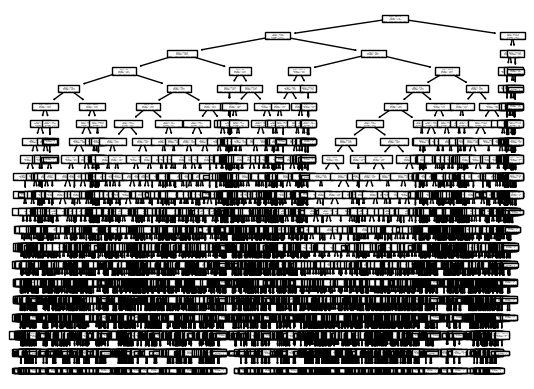

In [25]:

decision_tree=DecisionTreeClassifier(criterion='entropy',
                            splitter='best', 
                            max_depth=20, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0, 
                            max_features=None, 
                            random_state=1111, 
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.0, 
                            class_weight=None)
decision_tree.fit(X_train_rus, y_train_rus)
tree.plot_tree(decision_tree)

